In [1]:
using ForneyLab, LinearAlgebra, Plots

┌ Info: Recompiling stale cache file /Users/semihakbayrak/.julia/compiled/v1.2/ForneyLab/Eacon.ji for ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/semihakbayrak/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


This demo is prepared by being inspired by https://www.youtube.com/watch?v=aUkBa1zMKv4. An aircraft is flying at 50 unit above the sea level. We know the map of the terrain that aircraft is flying over. But we do not know the exact horizontal location of the aircraft. The aircraft is moving with 0.1 unit/h horizontally and has a sensor that can measure its altitude from the ground. Measurements are noisy and there is an uncertainty in movement due to irregularity in the wind.

In [2]:
function terrain(x)
    0.1*((x-18)^2)*cos(0.25*x) + 2
end

terrain (generic function with 1 method)

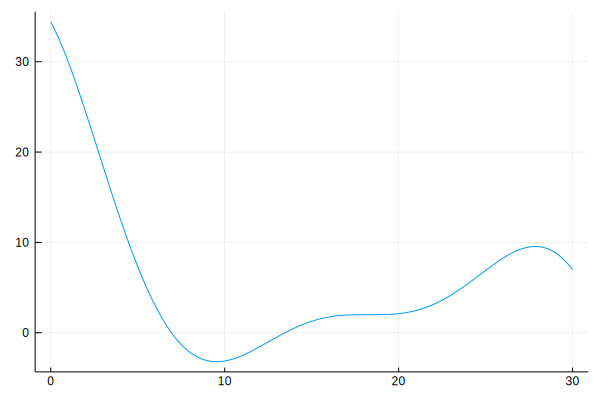

In [3]:
horizontal = collect(0:0.01:30)
verticle = terrain.(horizontal)
plot(horizontal,verticle,label=false)

In [4]:
measure_altitude(x) = 50 - terrain(x);

In [5]:
x_real = [3.0]
y_real = [terrain(x_real[end]) + randn()]
for i=1:249
    #x = 1 + x_real[end] + 0.1*randn()
    x = 0.1 + x_real[end] + 0.1*randn()
    push!(x_real,x)
    y = measure_altitude(x_real[end]) + 0.1*randn()
    push!(y_real,y)
end

In [6]:
# Model
g = FactorGraph()

@RV samples 
@RV weights 
@RV x_t_min ~ SampleList(samples, weights)

f(x) = x+0.1

@RV m_x_t ~ Nonlinear{Sampling}(x_t_min, g=f)
@RV x_t ~ GaussianMeanVariance(m_x_t,0.01)
@RV h_t ~ Nonlinear{Sampling}(x_t, g=measure_altitude)
@RV y_t ~ GaussianMeanVariance(h_t,1)

# Placeholders for prior
placeholder(samples, :samples, dims=(200,))
placeholder(weights, :weights, dims=(200,))

# Placeholder for data
placeholder(y_t, :y_t);

In [7]:
ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.42.3 (20191010.1750)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11909918726792819031 -->
 
 11909918726792819031 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 4537244703605253960 -->
 
 4537244703605253960 
 
 clamp_1 
 
<!-- 11909918726792819031--4537244703605253960 -->
 
 11909918726792819031--4537244703605253960 
 
 clamp_1 
 1 out 
 3 v 
 
<!-- 12940600061866890936 -->
 
 12940600061866890936 
 
 Nonlinear{Sampling} 
 nonlinear_1 
 
<!-- 11909918726792819031--12940600061866890936 -->
 
 11909918726792819031--12940600061866890936 
 
 m_x_t 
 1 out 
 2 m 
 
<!-- 7748183981118886098 -->
 
 7748183981118886098 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 16657208581762675307 -->
 
 16657208581762675307 
 
 clamp_2 
 
<!-- 7748183981118886098--16657208581762675307 -->
 
 7748183981118886098--16657208581762675307 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 7936434124738614153 -->
 
 7936434124738614153 
 
 Nonlinear{Sampling} 
 nonlinear_2 
 
<!-- 7748183981118886098--7936434124738614153 -->
 
 7748183981118886098--7936434124738614153 
 
 h_t 
 1 out 
 2 m 
 
<!-- 3907936416395801797 -->
 
 3907936416395801797 
 
 placeholder_weights 
 
<!-- 4085424487705445182 -->
 
 4085424487705445182 
 
 SampleList 
 samplelist_1 
 
<!-- 3907936416395801797--4085424487705445182 -->
 
 3907936416395801797--4085424487705445182 
 
 weights 
 3 w 
 1 out 
 
<!-- 12940600061866890936--4085424487705445182 -->
 
 12940600061866890936--4085424487705445182 
 
 x_t_min 
 1 out 
 2 in1 
 
<!-- 7936434124738614153--11909918726792819031 -->
 
 7936434124738614153--11909918726792819031 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 6091670630980961458 -->
 
 6091670630980961458 
 
 placeholder_samples 
 
<!-- 6091670630980961458--4085424487705445182 -->
 
 6091670630980961458--4085424487705445182 
 
 samples 
 2 s 
 1 out 
 
<!-- 8772660390232813360 -->
 
 8772660390232813360 
 
 placeholder_y_t 
 
<!-- 8772660390232813360--7748183981118886098 -->
 
 8772660390232813360--7748183981118886098 
 
 y_t 
 1 out 
 1 out

In [8]:
algo = sumProductAlgorithm(x_t) 
source_code = algorithmSourceCode(algo)
println(source_code)

begin

function init()

messages = Array{Message}(undef, 5)

messages[3] = Message(vague(SampleList))

return messages

end

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 5))

messages[1] = ruleSPSampleListOutNPP(nothing, Message(Multivariate, PointMass, m=data[:samples]), Message(Multivariate, PointMass, m=data[:weights]))
messages[2] = ruleSPNonlinearSOutNM(f, nothing, messages[1])
messages[3] = ruleSPGaussianMeanVarianceOutNSP(nothing, messages[2], Message(Univariate, PointMass, m=0.01))
messages[4] = ruleSPGaussianMeanVarianceMPNP(Message(Univariate, PointMass, m=data[:y_t]), nothing, Message(Univariate, PointMass, m=1))
messages[5] = ruleSPNonlinearSIn1MN(measure_altitude, messages[4], nothing)

marginals[:x_t] = messages[3].dist * messages[5].dist

return marginals

end

end # block


In [9]:
# Define algorithm
eval(Meta.parse(source_code));

┌ Info: Saved animation to 
│   fn = /Users/semihakbayrak/.julia/dev/ForneyLab/demo/figures/particle_filter.gif
└ @ Plots /Users/semihakbayrak/.julia/packages/Plots/vTdnV/src/animation.jl:98


Plots.AnimatedGif("/Users/semihakbayrak/.julia/dev/ForneyLab/demo/figures/particle_filter.gif")
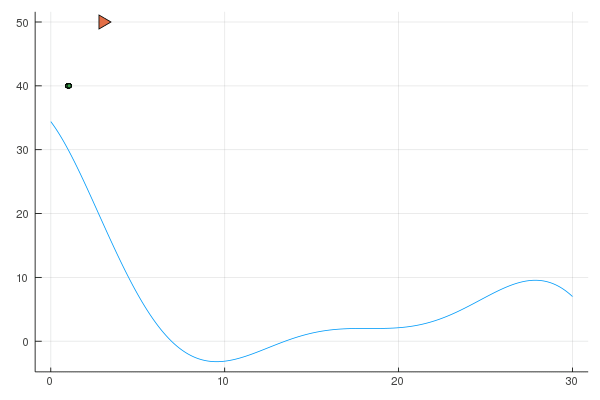

In [11]:
# Define values for prior statistics
sample_vals = rand(1:30,100)
weight_vals = ones(100)/100

sample_list = []
weight_list = []

#plt = plot(horizontal,verticle,label=false)

anim = @animate for t = 1:250
    # Prepare data and prior statistics
    data = Dict(:y_t       => y_real[t],
                :samples => sample_vals,
                :weights => weight_vals)
    
    # Execute algorithm
    marginals = step!(data)

    samples = marginals[:x_t].params[:s]
    weights = marginals[:x_t].params[:w]
    
    push!(sample_list,samples)
    push!(weight_list,weights)
    
    plt = plot(horizontal,verticle,label=false)
    plot!(plt,(x_real[t],50),seriestype = :scatter,markershape = :rtriangle,markersize=10,label=false)
    plot!(plt, samples,40 .*ones(100), seriestype = :scatter,markersize=250 .* weights,label=false)
    
end
gif(anim,"figures/particle_filter.gif", fps = 10)